## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [5]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [89]:
X_data = encoder_input_data#[:1000]
Y_data = decoder_input_data#[:1000]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (4368, 3822, 4)
Y_data (4368, 3822, 4)


In [90]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [91]:
i = 5
print(decode_seq(X_data[i:i+1])[0])
print(decode_seq(Y_data[i:i+1])[0])

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [92]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8538869424106563584
xla_global_id: -1
]


## Construct model

In [328]:
n_hidden = 8

In [329]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_35'), name='input_35', description="created by layer 'input_35'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_36'), name='input_36', description="created by layer 'input_36'")


In [330]:
splits = tf.split(input_train, num_or_size_splits=7 * 42, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 4), dtype=tf.float32, name=None), name='tf.concat_34/concat:0', description="created by layer 'tf.concat_34'")


In [331]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.00, recurrent_dropout = 0.00,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='gru_36/PartitionedCall:1', description="created by layer 'gru_36'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='gru_36/PartitionedCall:2', description="created by layer 'gru_36'")


In [332]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='repeat_vector_18/Tile:0', description="created by layer 'repeat_vector_18'")


In [333]:
decoder_stack_h = GRU(n_hidden, dropout = 0.00, recurrent_dropout = 0.00,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='gru_37/PartitionedCall:1', description="created by layer 'gru_37'")


In [334]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 13), dtype=tf.float32, name=None), name='activation_20/Softmax:0', description="created by layer 'activation_20'")


In [335]:
class RandomDropout(keras.layers.Layer):
    
    def __init__(self, train_rate, infer_rate, **kwargs):
        super(RandomDropout, self).__init__(**kwargs)
        self.train_rate = train_rate
        self.infer_rate = infer_rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.train_rate)
        else:
            return tf.nn.dropout(inputs, rate=self.infer_rate)
    

In [336]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout(train_rate=0.01, infer_rate=0.01)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 8), dtype=tf.float32, name=None), name='random_dropout_9/dropout/Mul_1:0', description="created by layer 'random_dropout_9'")


In [337]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 16), dtype=tf.float32, name=None), name='concatenate_18/concat:0', description="created by layer 'concatenate_18'")


In [338]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 13, 4), dtype=tf.float32, name=None), name='time_distributed_17/Reshape_1:0', description="created by layer 'time_distributed_17'")


In [339]:
back_splits = tf.split(out, num_or_size_splits=7*42, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='tf.concat_35/concat:0', description="created by layer 'tf.concat_35'")


In [340]:
model = Model(inputs = input_train, outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 3822, 4)]    0           []                               
                                                                                                  
 tf.split_34 (TFOpLambda)       [(None, 13, 4),      0           ['input_35[0][0]']               
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                            

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                                                  'tf.split_34[0][32]',           
                                                                  'tf.split_34[0][33]',           
                                                                  'tf.split_34[0][34]',           
                                                                  'tf.split_34[0][35]',           
                                                                  'tf.split_34[0][36]',           
                                                                  'tf.split_34[0][37]',           
                                                                  'tf.split_34[0][38]',           
                                                                  'tf.split_34[0][39]',           
                                                                  'tf.split_34[0][40]',           
                                                                  'tf.split_34[0][41]',           
          

                                                                  'tf.split_34[0][115]',          
                                                                  'tf.split_34[0][116]',          
                                                                  'tf.split_34[0][117]',          
                                                                  'tf.split_34[0][118]',          
                                                                  'tf.split_34[0][119]',          
                                                                  'tf.split_34[0][120]',          
                                                                  'tf.split_34[0][121]',          
                                                                  'tf.split_34[0][122]',          
                                                                  'tf.split_34[0][123]',          
                                                                  'tf.split_34[0][124]',          
          

                                                                  'tf.split_34[0][198]',          
                                                                  'tf.split_34[0][199]',          
                                                                  'tf.split_34[0][200]',          
                                                                  'tf.split_34[0][201]',          
                                                                  'tf.split_34[0][202]',          
                                                                  'tf.split_34[0][203]',          
                                                                  'tf.split_34[0][204]',          
                                                                  'tf.split_34[0][205]',          
                                                                  'tf.split_34[0][206]',          
                                                                  'tf.split_34[0][207]',          
          

                                                                  'tf.split_34[0][281]',          
                                                                  'tf.split_34[0][282]',          
                                                                  'tf.split_34[0][283]',          
                                                                  'tf.split_34[0][284]',          
                                                                  'tf.split_34[0][285]',          
                                                                  'tf.split_34[0][286]',          
                                                                  'tf.split_34[0][287]',          
                                                                  'tf.split_34[0][288]',          
                                                                  'tf.split_34[0][289]',          
                                                                  'tf.split_34[0][290]',          
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
          

                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4),                                                   
                                 (None, 13, 4)]                                                   
                                                                                                  
 tf.concat_35 (TFOpLambda)      (None, 3822, 4)      0           ['tf.split_35[0][0]',            
          

                                                                  'tf.split_35[0][74]',           
                                                                  'tf.split_35[0][75]',           
                                                                  'tf.split_35[0][76]',           
                                                                  'tf.split_35[0][77]',           
                                                                  'tf.split_35[0][78]',           
                                                                  'tf.split_35[0][79]',           
                                                                  'tf.split_35[0][80]',           
                                                                  'tf.split_35[0][81]',           
                                                                  'tf.split_35[0][82]',           
                                                                  'tf.split_35[0][83]',           
          

                                                                  'tf.split_35[0][157]',          
                                                                  'tf.split_35[0][158]',          
                                                                  'tf.split_35[0][159]',          
                                                                  'tf.split_35[0][160]',          
                                                                  'tf.split_35[0][161]',          
                                                                  'tf.split_35[0][162]',          
                                                                  'tf.split_35[0][163]',          
                                                                  'tf.split_35[0][164]',          
                                                                  'tf.split_35[0][165]',          
                                                                  'tf.split_35[0][166]',          
          

                                                                  'tf.split_35[0][240]',          
                                                                  'tf.split_35[0][241]',          
                                                                  'tf.split_35[0][242]',          
                                                                  'tf.split_35[0][243]',          
                                                                  'tf.split_35[0][244]',          
                                                                  'tf.split_35[0][245]',          
                                                                  'tf.split_35[0][246]',          
                                                                  'tf.split_35[0][247]',          
                                                                  'tf.split_35[0][248]',          
                                                                  'tf.split_35[0][249]',          
          

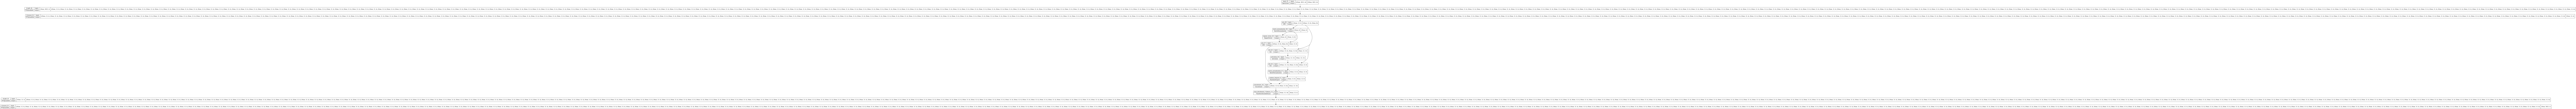

In [341]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [343]:
batch_size = 64      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 500         # Number of epochs to train for.

In [344]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/500
55/55 [==============================] - 11s 155ms/step - loss: 1.2582 - accuracy: 0.4197 - val_loss: 1.2264 - val_accuracy: 0.4446
Epoch 2/500
55/55 [==============================] - 7s 129ms/step - loss: 1.1425 - accuracy: 0.4799 - val_loss: 1.0823 - val_accuracy: 0.5061
Epoch 3/500
55/55 [==============================] - 7s 130ms/step - loss: 0.9881 - accuracy: 0.5536 - val_loss: 0.8913 - val_accuracy: 0.6026
Epoch 4/500
55/55 [==============================] - 7s 130ms/step - loss: 0.7356 - accuracy: 0.6817 - val_loss: 0.6104 - val_accuracy: 0.7291
Epoch 5/500
55/55 [==============================] - 7s 130ms/step - loss: 0.4867 - accuracy: 0.7901 - val_loss: 0.3943 - val_accuracy: 0.8387
Epoch 6/500
55/55 [==============================] - 8s 138ms/step - loss: 0.3274 - accuracy: 0.8733 - val_loss: 0.2569 - val_accuracy: 0.9038
Epoch 7/500
55/55 [==============================] - 8s 139ms/step - loss: 0.2068 - accuracy: 0.9250 - val_loss: 0.1587 - val_accuracy: 0.942

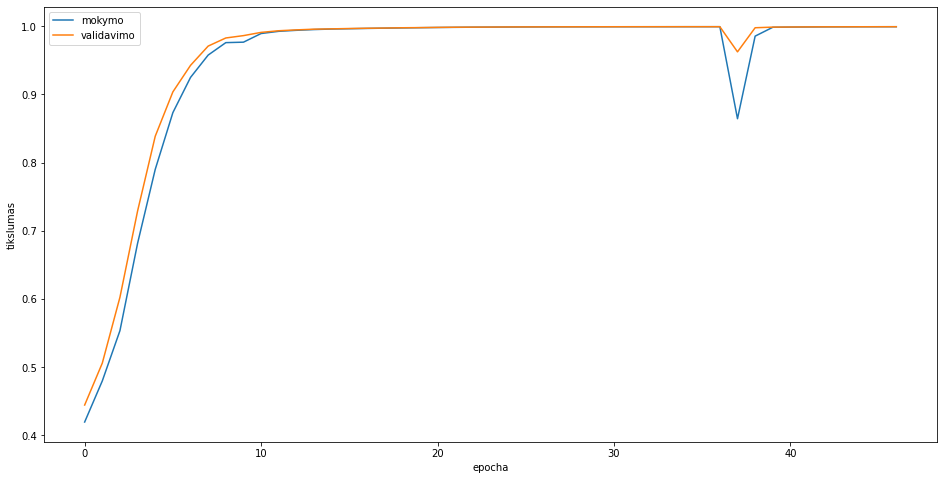

In [345]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

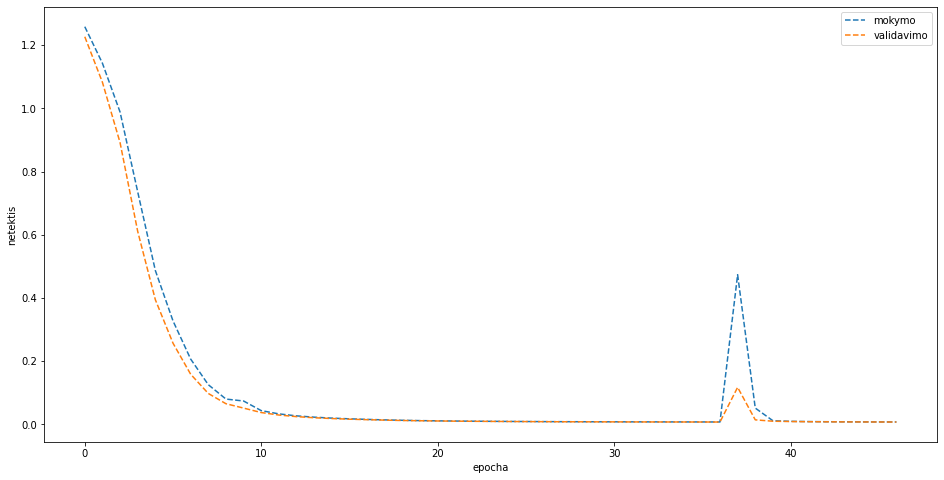

In [346]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [347]:
model.save("data/ncbi_02/model_gru_bi_256_8")

INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256_8/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_gru_bi_256_8/assets
